In [ ]:
!pip install transformers tokenizers evaluate huggingface_hub --quiet

import numpy as np

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [ ]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained('raygx/GPT2-NepSA-T1')
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/GPT2-NepSA-T1', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [ ]:
from transformers import AutoConfig
from transformers import BertTokenizerFast

using = 'bert' # Model to use
use_config = False # When True initializes the model with random weights and when true initilizes the model with pretrained weigths

if using == 'gpt':
  config = AutoConfig.from_pretrained(
            'distilgpt2',
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
          )
  
  print("Loading Model 'distilGPT2")
  if use_config:
    print("Intialization: New")
    model = TFAutoModelForSequenceClassification.from_config(config)
  else:    
    print("Intialization: Pretrained")
    model = TFAutoModelForSequenceClassification.from_pretrained(config = config)
  
if using == 'bert':  
  config = AutoConfig.from_pretrained(
            'distilbert-base-uncased',
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
          )
  
  print("Loading Model 'distilbert-base-uncased")
  if use_config:
    print("Intialization: New")
    model = TFAutoModelForSequenceClassification.from_config(config)
  else:
    print("Intialization: Pretrained")
    model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',config = config)

  tokenizer = BertTokenizerFast.from_pretrained("raygx/GPT2-Nepali-Casual-LM")
  
model.resize_token_embeddings(len(tokenizer))

Loading Model 'distilbert-base-uncased
Intialization: Pretrained


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
print(model.config)
print(model.summary())

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 3,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.29.2",
  "vocab_size": 50000
}

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 81321984  
 nLaye

In [ ]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.009)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Data Loading and Preparation

In [ ]:
data = datasets.load_dataset("raygx/NepCov19Tweets")
data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33471
    })
})

In [ ]:
data = data.shuffle(999)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 6695
    })
})

In [ ]:
def prepareLabels(row):
    if row['labels'] == -1:
        row['labels'] = 2
        
    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/26776 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6695 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 6695
    })
})


In [ ]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/26776 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/6695 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 573 ms, sys: 300 ms, total: 873 ms
Wall time: 11.1 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6695
    })
})

In [ ]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [2], 'text': ['र स्वास्थ्यकर्मीहरूलाई भ्याईनभ्याई छ तर यस्तो स्थितिमा अस्पतालको क्षमता व्यवस्थापनका लागि कुनै योजना छैन अति बिरामीका लागि सघन कक्षमा शय्याको अभाव छ साथै अस्पतालहरूको अभाव हुँदा कोभिड को उपचार आवश्यक रहेका गम्भीर बिरामीहरू घरमा एक्लै रहन बाध्य छन्']}
[[96, 10183, 1146, 4389, 4461, 194, 15652, 76, 437, 1078, 6522, 5938, 2355, 9466, 352, 658, 1086, 569, 1598, 22052, 352, 15115, 13231, 41128, 2109, 76, 1171, 1132, 777, 2109, 1286, 1752, 364, 1273, 964, 828, 2312, 38775, 1904, 6440, 4229, 2276, 340]]
['र स्वास्थ्यकर्मीहरूलाई भ्याईनभ्याई छ तर यस्तो स्थितिमा अस्पतालको क्षमता व्यवस्थापनका लागि कुनै योजना छैन अति बिरामीका लागि सघन कक्षमा शय्याको अभाव छ साथै अस्पतालहरूको अभाव हुँदा कोभिड को उपचार आवश्यक रहेका गम्भीर बिरामीहरू घरमा एक्लै रहन बाध्य छन्']


In [ ]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [ ]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training **Batch 1**

In [ ]:
%%time

n_epoch = 5
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/5
1673/1673 [==============================] - 224s 123ms/step - loss: 0.9353 - val_loss: 0.8708
Epoch 2/5
1673/1673 [==============================] - 202s 121ms/step - loss: 0.8419 - val_loss: 0.8323
Epoch 3/5
1673/1673 [==============================] - 202s 121ms/step - loss: 0.7913 - val_loss: 0.8294
Epoch 4/5
1673/1673 [==============================] - 209s 125ms/step - loss: 0.7432 - val_loss: 0.7777
Epoch 5/5
1673/1673 [==============================] - 202s 121ms/step - loss: 0.7035 - val_loss: 0.7557
{'loss': [0.9353426694869995, 0.8418939709663391, 0.7913075685501099, 0.7432467937469482, 0.7035285234451294], 'val_loss': [0.8708232641220093, 0.8323315978050232, 0.8294496536254883, 0.7777042984962463, 0.7556832432746887]}
CPU times: user 13min 44s, sys: 32.3 s, total: 14min 16s
Wall time: 20min 9s


<Axes: >

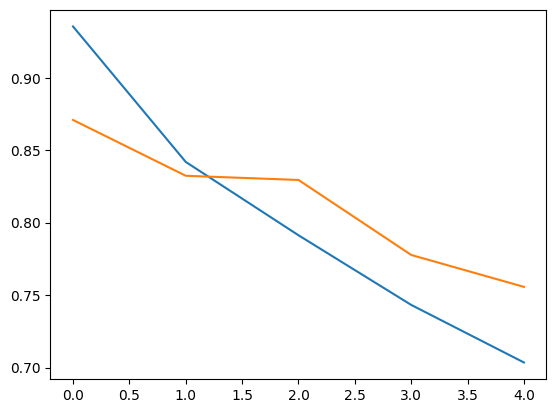

In [ ]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [ ]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 11min 45s, sys: 2.48 s, total: 11min 47s
Wall time: 11min 47s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.6520091518639033
Precision-Score 0.6604205474074833
Recall-Score 0.6791635548917102
accuracy_Score 0.6791635548917102


**Plotting Confusion Matrix**

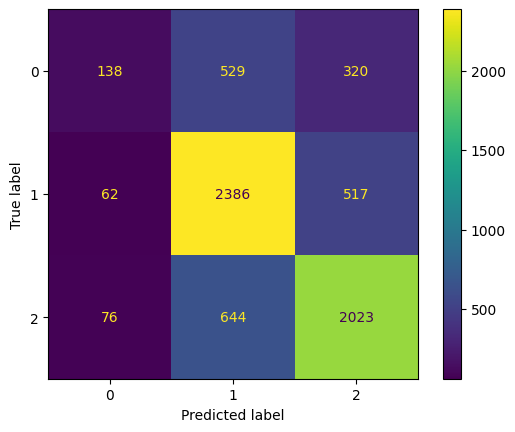

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
### Pushing Model to hub
# if using=='gpt':
#   model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L4H:Batch 1:Epoch 20; lr=2e-6")

1/0

## Training **Batch 2**

In [ ]:
%%time
n_epoch = 5
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/5
   1/1673 [..............................] - ETA: 5:50 - loss: 0.6791

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


1673/1673 [==============================] - 201s 120ms/step - loss: 0.6605 - val_loss: 0.7865
Epoch 2/5
1673/1673 [==============================] - 202s 121ms/step - loss: 0.6242 - val_loss: 0.7718
Epoch 3/5
1673/1673 [==============================] - 204s 122ms/step - loss: 0.5863 - val_loss: 0.7808
Epoch 4/5
1673/1673 [==============================] - 203s 121ms/step - loss: 0.5452 - val_loss: 0.7672
Epoch 5/5
1673/1673 [==============================] - 203s 121ms/step - loss: 0.5136 - val_loss: 0.7871
{'loss': [0.6605311632156372, 0.6242197155952454, 0.586344838142395, 0.5452464818954468, 0.5136363506317139], 'val_loss': [0.7865216135978699, 0.7717918753623962, 0.7807803153991699, 0.7672199606895447, 0.787090003490448]}
CPU times: user 13min 35s, sys: 32.4 s, total: 14min 8s
Wall time: 18min 52s


<Axes: >

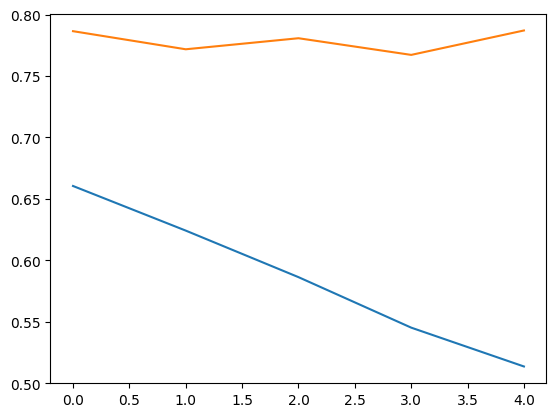

In [ ]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [ ]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  def batchPrediction(rows):
    pass

  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 11min 47s, sys: 2.55 s, total: 11min 50s
Wall time: 11min 50s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.6766844347751663
Precision-Score 0.6741921492652714
Recall-Score 0.6906646751306945
accuracy_Score 0.6906646751306945


**Plotting Confusion Matrix**

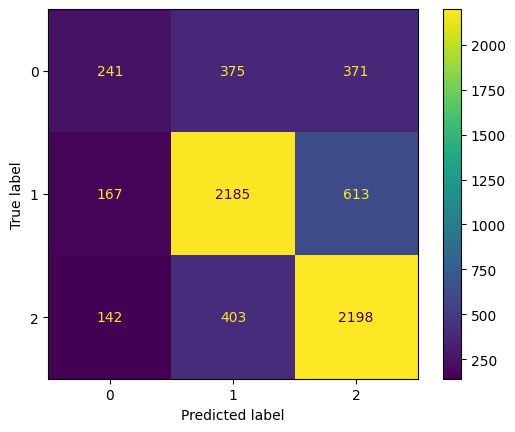

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
# tokenizer.push_to_hub("raygx/GPT2-NepSA-T1")

In [ ]:
### Pushing Model to hub
# if using=='gpt':
#   model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L4H:Batch 1:Epoch 40")